In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


# Bayesflow for Amortized Bayesian Inference
import bayesflow as bf
from bayesflow.diagnostics import plots as bf_plots


# Internal helper functions
from load_data import get_data
from train_model import get_trained_model, train_model, get_approximator


2025-04-20 16:11:37.417047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-20 16:11:37.505911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-20 16:11:37.532282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 16:11:37.701642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-20 16:11:38.844823: W tensorflow/compiler/tf2

# Amortize NOvA model

We will do this based on the model **expectations** generated offline.

Using model expectations is technically wrong: for ABI (or any other Simulated Bayesian Inference) we should use model **predictions**, i.e. expectations subjected to the uncertainty around making a measurement (Poisson statistics in case of NOvA experiment).

Using expectations will cause the Amortized model to create approximate posteriors that are overly constrained, i.e. the model will be too certain. Will re-do using model predictions later, in a separate notebook.


# Generating expectations

The expectations were generated offline using CAFAna.

The expectations were thrown from a stats-only prior:
* `delta_cp`: Uniform(0, 2) (in units of pi)
* `sinsq_2theta13`: Gaussian(0.0851, 0.002)
* `sinsq_theta23`: Uniform(0.2, 0.8)
* `abs_delta_m32`: Uniform(2, 3) (in x10e-3 eV^2 units)
* `mass_ordering`: UniformDiscrete(0, 1) (inverted & normal mass ordering, converted to -1 & 1 and multiplied by abs_delta_m32 before generating expectation)

For each throw, expectation spectra were made for FHC nue, FHC nueLowE, RHC nue, FHC numu and RHC numu samples (the 4 quartiles were merged into one spectrum). In total, 20M throws were made for training offline, and saved into .root files.

# Loading & preparing the data for training

Here we load ~10M model expectation throws from prior and devote a 100,000 for validations & 10,000 for testing.
The data will be transformed for the purpose of training:
1. Spectra bins that are always 0 will be removed (only nue).
2. All the spectra will be merged into one vector/spectrum (TODO: Keeping them separate will be necessary for more complex networks)
3. Both the spectra (observables | summary variables) and the input parameters (parameters | inference parameters) will be normalized to -1 & 1 by subtracting mean & dividing by std.
4. The data is then split into testing (10k), validation (100k) and training (remaining) datasets.
5. The means & stds from the normalization needs to be saved for later retrieval.

In [2]:
# Get the first 10 data files
data_files = []
for data_file in glob.glob("../../emulated_data/emulated_data_seed1*.root"):
    data_files.append(data_file)

# Load the data
train, validate, test, spectra_norm, true_norm = get_data(data_files, 
                                                          validation_events=100_000,
                                                          testing_events=10_000)

loading 1/10: ../../emulated_data/emulated_data_seed14_samples2000000.root
loading 2/10: ../../emulated_data/emulated_data_seed10_samples2000000.root
loading 3/10: ../../emulated_data/emulated_data_seed13_samples2000000.root
loading 4/10: ../../emulated_data/emulated_data_seed12_samples2000000.root
loading 5/10: ../../emulated_data/emulated_data_seed11_samples2000000.root
loading 6/10: ../../emulated_data/emulated_data_seed16_samples2000000.root
loading 7/10: ../../emulated_data/emulated_data_seed17_samples2000000.root
loading 8/10: ../../emulated_data/emulated_data_seed19_samples2000000.root
loading 9/10: ../../emulated_data/emulated_data_seed18_samples2000000.root
loading 10/10: ../../emulated_data/emulated_data_seed15_samples2000000.root


In [3]:
print(f"Training shape for spectra train[0]: {train[0].shape}")
print(f"Training shape for parameters train[1]: {train[1].shape}")
print(f"Validation shape for spectra validate[0]: {validate[0].shape}")
print(f"Validation shape for parameters validate[1]: {validate[1].shape}")
print(f"Testing shape for spectra test[0]: {test[0].shape}")
print(f"Testing shape for parameters test[1]: {test[1].shape}")

print(f"Spectra normalization: {spectra_norm}")
print(f"True parameter normalization: {true_norm}")

# Put the data into format understood by BayesFlow & convert to float32 for
# better GPU performance
training_data= {
      "parameters": train[1].astype(np.float32),
      "observables": train[0].astype(np.float32)
}

validation_data = {
      "parameters": validate[1].astype(np.float32),
      "observables": validate[0].astype(np.float32)
}

testing_data = {
      "parameters": test[1].astype(np.float32),
      "observables": test[0].astype(np.float32)
}

# We will look at the first 5 events in the training more closely
testing_data_examples = {
      "parameters": test[1][:5].astype(np.float32),
      "observables": test[0][:5].astype(np.float32)
}

# Save the normalization values for later re-use
output_dir = "../checkpoints/emulated_test_10M"
os.makedirs(output_dir, exist_ok=True)
np.savez(f"{output_dir}/normalization.npz", spectra_norm=spectra_norm, true_norm=true_norm)

Training shape for spectra train[0]: (19890000, 72, 1)
Training shape for parameters train[1]: (19890000, 5)
Validation shape for spectra validate[0]: (100000, 72, 1)
Validation shape for parameters validate[1]: (100000, 5)
Testing shape for spectra test[0]: (10000, 72, 1)
Testing shape for parameters test[1]: (10000, 5)
Spectra normalization: (8.014608812777325, 8.163387084559538)
True parameter normalization: (array([1.00004865, 0.08509967, 0.50002362, 2.4999888 , 0.4999854 ]), array([0.57731694, 0.00200103, 0.17321698, 0.28869116, 0.500001  ]))


# Train the model

**Summary network**: Simple `LSTM` network to summarize the spectra. Tested simple `MLP`, `Transformer` and `DeepSet`, although more complex variants of these are yet to be tested. I expect `DeepSet` and `Transformer` to perform better, but the spectra need to be kept separate for FHC/RHC nue/nueLowE/numu to really take advantage of those networks.


**Inference network**: `FlowMatching` used to convert priors into posteriors, conditioned on our summary network above. Tested `CouplingFlow` too, but `FlowMatching` performed better: which is what I expected given that it is known to perform better on more complex posteriors (and e.g. delta_cp vs th23 can get complex).

Batch size is 2048 for speed (10M samples is a lot), with 10 epochs (3-6 would likely suffice).

Network trained using:
- NVIDIA RTX 3070 with ~8.2Gb VRAM
- AMD Ryzen 9 3900XT 12 (24 logical) cores
- 32 Gb RAM, 64 GB SWAP RAM

Bottleneck1: `RAM + SWAP RAM` is too small to fit whole 20M dataset, and I would like to use 100M dataset in the future. TODO: use Bayesflow's `DiskDataset` instead of `OfflineDataset` object, although I'm not sure if that will actually help.

Bottleneck2: `VRAM` is too low for sampling from the posteriors for all the validation datasets after the training. TODO: Try doing it sequentially, e.g. 10 datasets at a time.

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
2025-04-20 16:16:24.151194: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1745162184.741134   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162184.796268   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162184.797286   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162184.812673   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162184.813702   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162184.814426   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162184.830210   22197 gpu_timer.cc:114] Skip

Epoch 1/10


W0000 00:00:1745162191.858742   22557 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162191.873884   22557 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162191.882289   22557 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162191.883123   22557 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162191.908304   22557 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162191.908878   22557 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162191.921142   22557 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162191.921944   22557 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162191.922532   22557 gp

   2/9712 ━━━━━━━━━━━━━━━━━━━━ 8:09 50ms/step - loss: 3.2813 - loss/inference_loss: 3.2813  

W0000 00:00:1745162192.742710   22560 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162192.743824   22560 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162192.744393   22560 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162192.744956   22560 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162192.745508   22560 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162192.746074   22560 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162192.746638   22560 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162192.747398   22560 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162192.748134   22560 gp

8676/9712 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - loss: 0.6083 - loss/inference_loss: 0.6083

W0000 00:00:1745162591.275026   22551 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162591.275636   22551 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162591.276193   22551 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162591.276750   22551 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162591.277282   22551 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162591.277816   22551 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162591.279861   22551 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162591.280597   22551 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162591.281126   22551 gp

8679/9712 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - loss: 0.6083 - loss/inference_loss: 0.6083

2025-04-20 16:23:11.520334: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:310] gpu_async_0 cuMemAllocAsync failed to allocate 8257650688 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 1651572736/8229289984
2025-04-20 16:23:11.520376: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:315] Stats: Limit:                      6128336896
InUse:                        40632969
MaxInUse:                   1240641257
NumAllocs:                     5048466
MaxAllocSize:                226492432
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2025-04-20 16:23:11.520465: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:64] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2025-04-20 16:23:11.520474: E external/local_xla/xla/stream_executor

9712/9712 ━━━━━━━━━━━━━━━━━━━━ 454s 46ms/step - loss: 0.5860 - loss/inference_loss: 0.5860 - val_loss: 0.3413 - val_loss/inference_loss: 0.3413
Epoch 2/10
   1/9712 ━━━━━━━━━━━━━━━━━━━━ 10:58 68ms/step - loss: 0.3903 - loss/inference_loss: 0.3903

W0000 00:00:1745162641.219893   22553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162641.220631   22553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162641.221297   22553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162641.221960   22553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162641.222627   22553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162641.223304   22553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162641.224023   22553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162641.224678   22553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745162641.225320   22553 gp

9712/9712 ━━━━━━━━━━━━━━━━━━━━ 447s 46ms/step - loss: 0.2946 - loss/inference_loss: 0.2946 - val_loss: 0.1688 - val_loss/inference_loss: 0.1688
Epoch 3/10
9712/9712 ━━━━━━━━━━━━━━━━━━━━ 452s 47ms/step - loss: 0.1870 - loss/inference_loss: 0.1870 - val_loss: 0.1285 - val_loss/inference_loss: 0.1285
Epoch 4/10
9712/9712 ━━━━━━━━━━━━━━━━━━━━ 456s 47ms/step - loss: 0.1485 - loss/inference_loss: 0.1485 - val_loss: 0.1161 - val_loss/inference_loss: 0.1161
Epoch 5/10
9712/9712 ━━━━━━━━━━━━━━━━━━━━ 455s 47ms/step - loss: 0.1286 - loss/inference_loss: 0.1286 - val_loss: 0.0889 - val_loss/inference_loss: 0.0889
Epoch 6/10
9712/9712 ━━━━━━━━━━━━━━━━━━━━ 457s 47ms/step - loss: 0.1157 - loss/inference_loss: 0.1157 - val_loss: 0.1187 - val_loss/inference_loss: 0.1187
Epoch 7/10
9712/9712 ━━━━━━━━━━━━━━━━━━━━ 460s 47ms/step - loss: 0.1066 - loss/inference_loss: 0.1066 - val_loss: 0.0761 - val_loss/inference_loss: 0.0761
Epoch 8/10
9712/9712 ━━━━━━━━━━━━━━━━━━━━ 456s 47ms/step - loss: 0.0995 - loss/in

Model: "continuous_approximator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flow_matching (FlowMatching)    │ ?                      │       300,549 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_series_network             │ ?                      │       145,152 │
│ (TimeSeriesNetwork)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,337,105 (5.10 MB)

 Trainable params: 445,701 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 891,404 (3.40 MB)

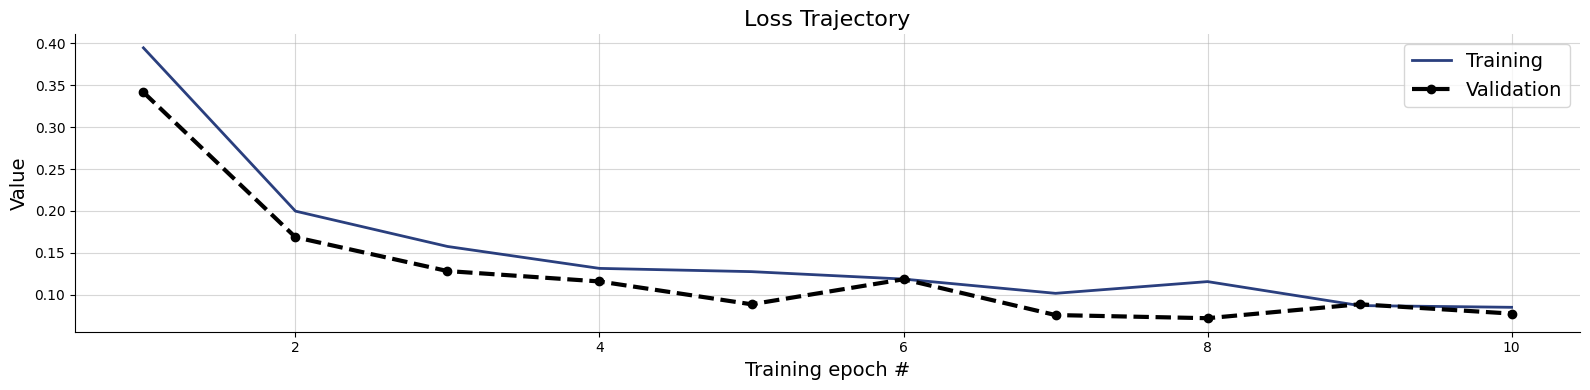

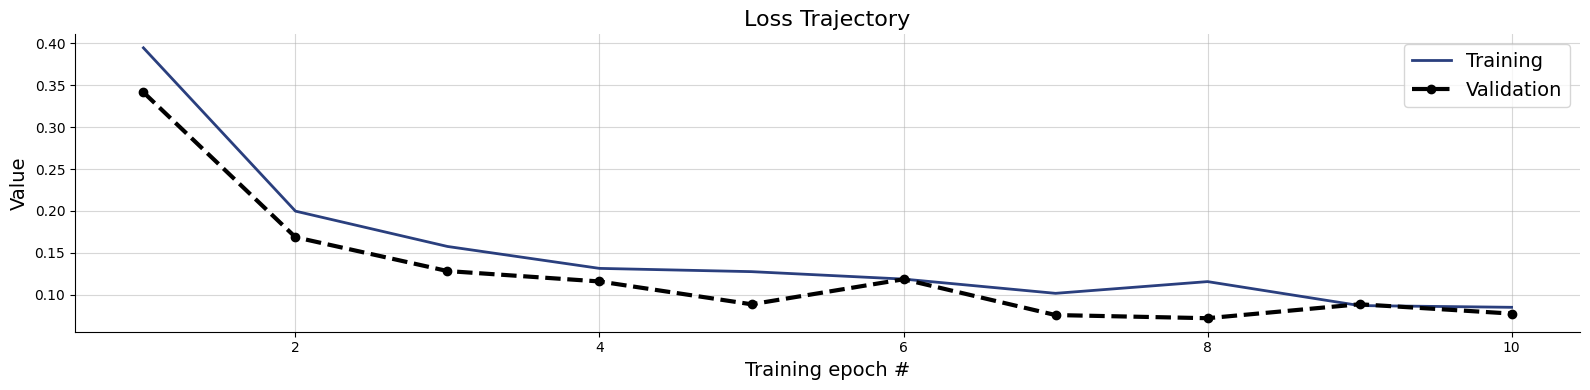

In [4]:
# Get the model
approximator = get_approximator()

# Train the model, this will take a while...
history = train_model(approximator, 
                      training_data=training_data, 
                      validation_data=validation_data,
                      epochs=10)

# Print the network summary.
# TODO: build the model prior to training & put the summary there.
approximator.summary()

# Save the model
approximator.save(f"{output_dir}/approximator.keras")

# Plot the loss history!
# TODO: Evaluate the model before training & prepend to the history prior to plotting
bf_plots.loss(history)

# Get all the diagnostics

We will get diagnostics:
1. Rank "calibration" plots (histogram & ECDF). Link for explanation: https://hyunjimoon.github.io/SBC/articles/rank_visualizations.html
2. Recovery plot: https://pmc.ncbi.nlm.nih.gov/articles/PMC10522800/
3. Contraction plot: https://betanalpha.github.io/assets/case_studies/modeling_and_inference.html#33_bayesian_calibration



In [5]:

# Sample 500 posterior samples from the model for all the testing datasets
test_posterior = approximator.sample(conditions=testing_data, num_samples=100)

W0000 00:00:1745166743.591129   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166743.592778   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166743.594216   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166743.595627   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166743.597144   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166743.598673   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166743.600441   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166743.601856   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166743.603262   22197 gp

It took 20s to generate 100 samples for 10,000 datasets, so 1,000,000 fully independent samples!
Now, this is equivalent to:
1. Aria-CAFAna: 1M * autocorrelation (100-1000) = 100M-1B MCMC samples
2. Stan-CAFAna: 1M * autocorrelation (~10) = 500M MCMC samples

But it took 20s on one GPU, rather than 1-3 days on 5,000 CPUs.

What's even more impressive, is that sampling 10x more samples takes the same
amount of time (but crashes 50% of the time because of limited VRAM on my GPU),
which means we're likely bottlenecked by moving arrays to/from the GPU, not by
actually drawing samples from the posterior. Finding out real computing
performance could be a bit more complicated than evaluating a single run.

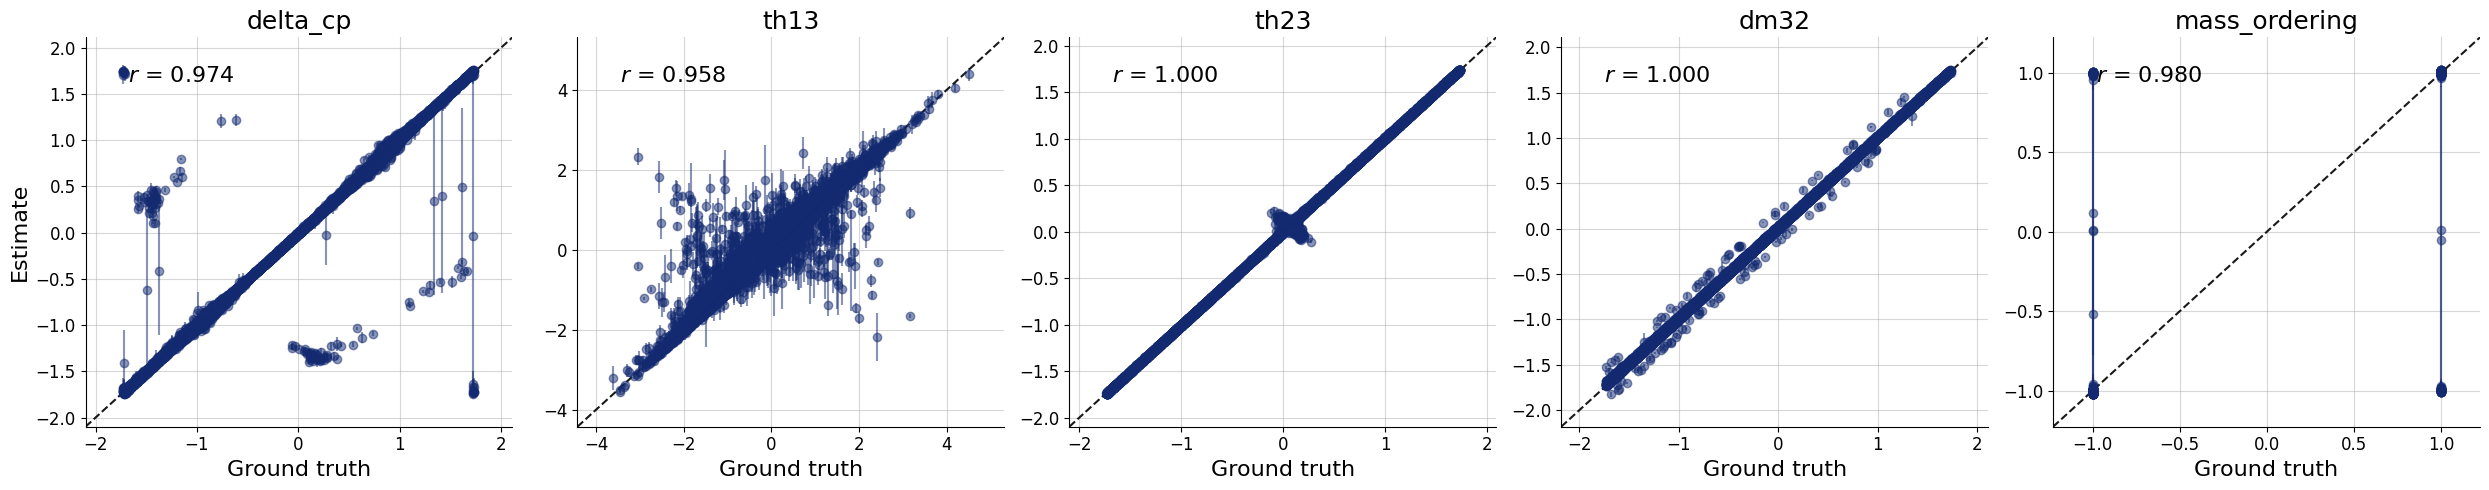

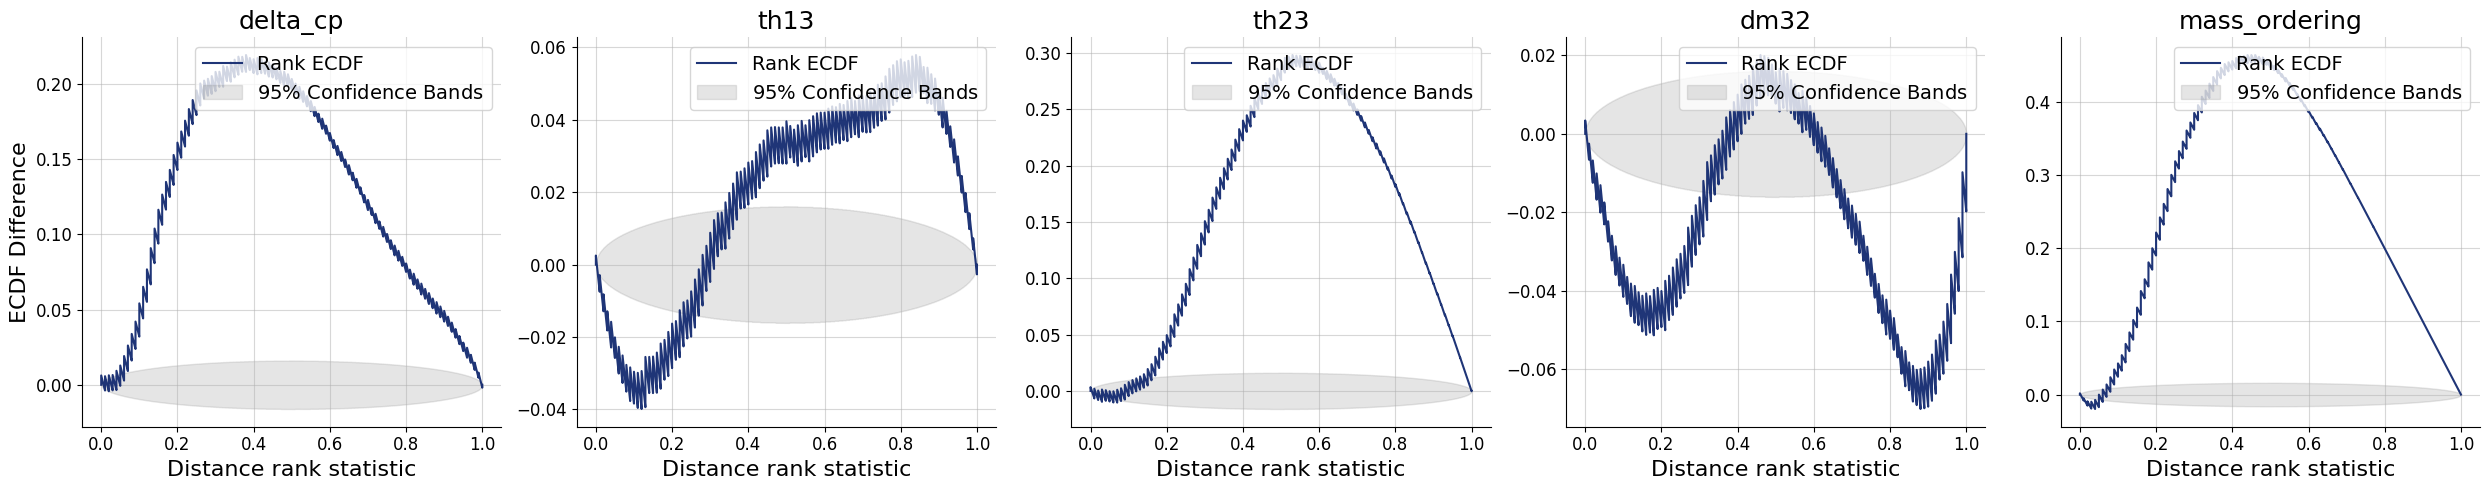

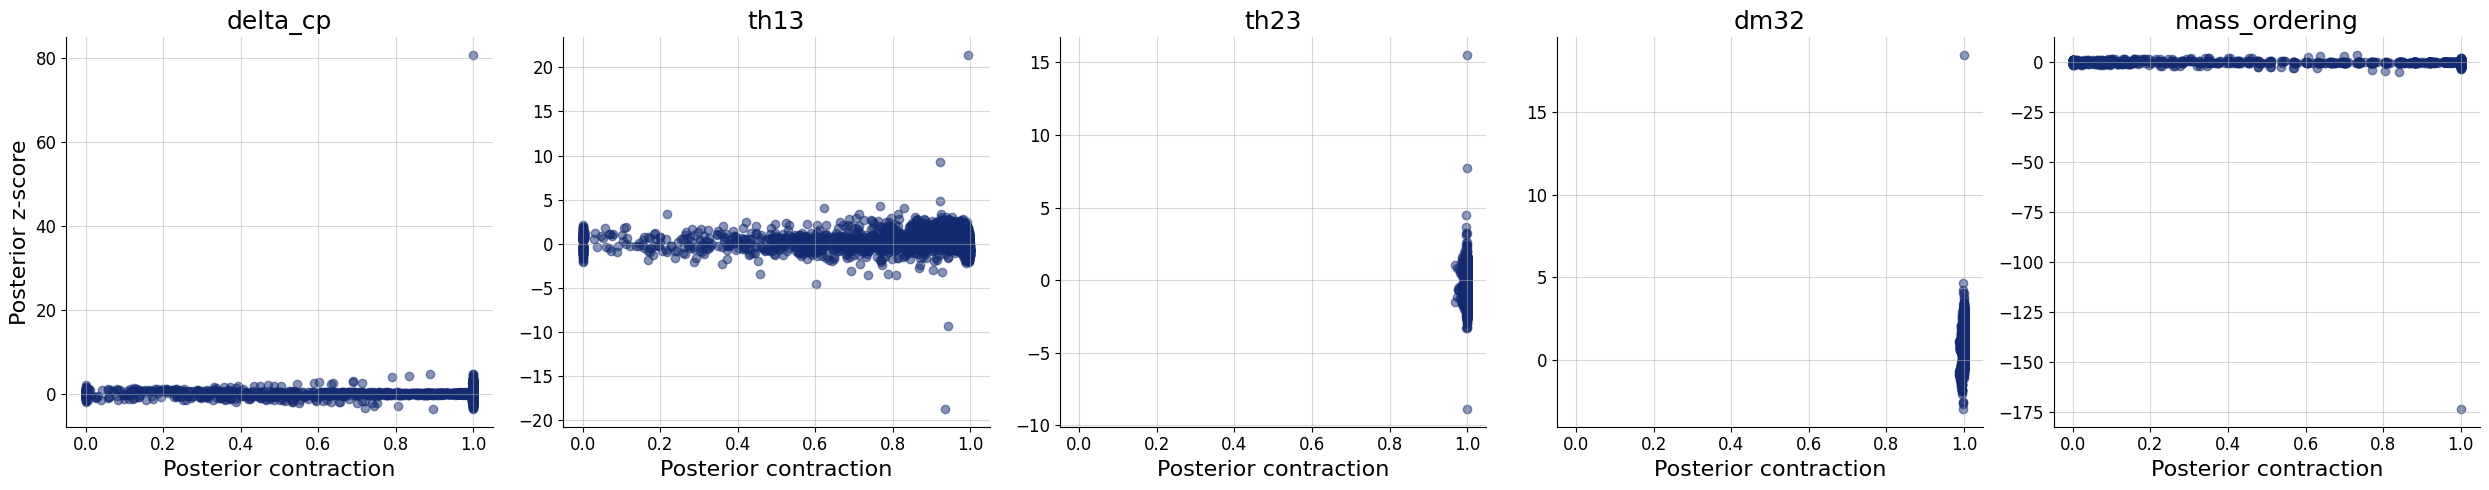

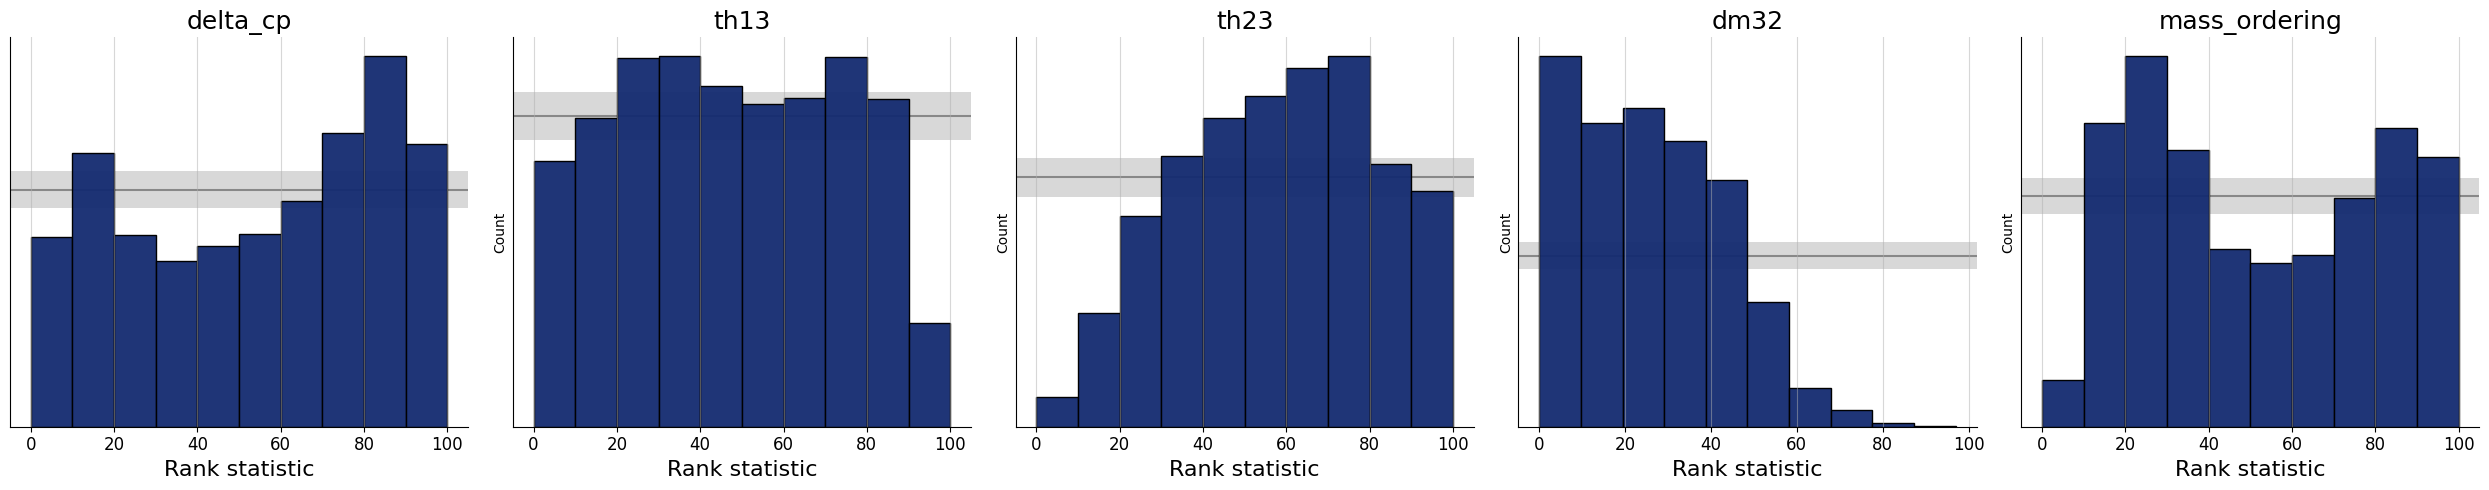

In [6]:
# Parameter names for plotting
variable_names = ["delta_cp", "th13", "th23", "dm32", "mass_ordering"]

# Plots to generate
plot_fns = {
  "recovery": bf_plots.recovery,
  "calibration_ecdf": bf_plots.calibration_ecdf,
  "z_score_contraction": bf_plots.z_score_contraction,
  "calibration_histogram": bf_plots.calibration_histogram
}

# Generate the plots
for k, plot_fn in plot_fns.items():
  if  k == "calibration_ecdf":
      plot_fn(
          estimates=test_posterior,
          targets=testing_data,
          variable_names=variable_names,
          difference=True,
          rank_type="distance"
      )
  else:
      plot_fn(
          estimates=test_posterior,
          targets=testing_data,
          variable_names=variable_names
      )

# Diagnostics interpretation

We are successfully recovering the true input values from the validation datasets when draw 500 samples per dataset, but there are also clear issues with the training:
1. Recovery plots look good with high R values. There is some oddity in delta_cp, which might be expected given it's a complex parameter with multiple degeneracies (inc. 0 == 2, which are on opposite sides of the posterior).
2. ECDF and 1D rank histograms plots clearly show that the model is too certain for some of the parameters (delta_cp & mass ordering) too uncertain for th23, underestimating delta_cp & theta_23, and overestimating dm32 & th13.
3. Concentration plots tell us that the NOvA data is strongly informative for dm32 & theta23, and can be informative about delta_cp, theta_13 and mass ordering, but:
   - some datasets do not describe these parameters well. This only makes sense for delta_cp & mass ordering (and would make sense for th23 too). 
   - The behaviour of th13 is a bit more concerning: on the other hand, we did
      sample from a strong gaussian prior, and NOvA data will not add much to that,
      unless the value of th13 is far away from the prior.
   - The perhaps we are only overfitting for a (large) fraction of datasets, but not all!


All in all, this is not surprising given that we used the emulated datasets for training rather than actual predictions.
If this behaviour persists for when using the simulated predictions for training (separate notebook), then we can consider:
1. Simplifying the network
2. Adding far more data
3. Increasing dropout (using default, so 0.05)

# Examining few posteriors

We will now sample posteriors for 5 datasets and create triangle plots for each one of them, marking the true input parameter values on the 1D histograms.


In [7]:
# Generate 10,000 posterior samples for the first 5 events in the testing dataset
test_posterior = approximator.sample(conditions=testing_data_examples, num_samples=10_000)

W0000 00:00:1745166779.954875   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166779.955435   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166779.955938   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166779.956434   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166779.956936   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166779.957443   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166779.957948   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166779.958457   22197 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745166779.958959   22197 gp

In [8]:
# Convert the posterior samples back to the original parameter space
std = true_norm[1]
mean = true_norm[0]
test_posterior['parameters'] = test_posterior['parameters'] * std[None, None, :] + mean[None, None, :]
testing_data_examples['parameters'] = testing_data_examples['parameters'] * std[None, :] + mean[None, :]

Plotting pairs posterior 0
Plotting pairs posterior 1
Plotting pairs posterior 2
Plotting pairs posterior 3
Plotting pairs posterior 4


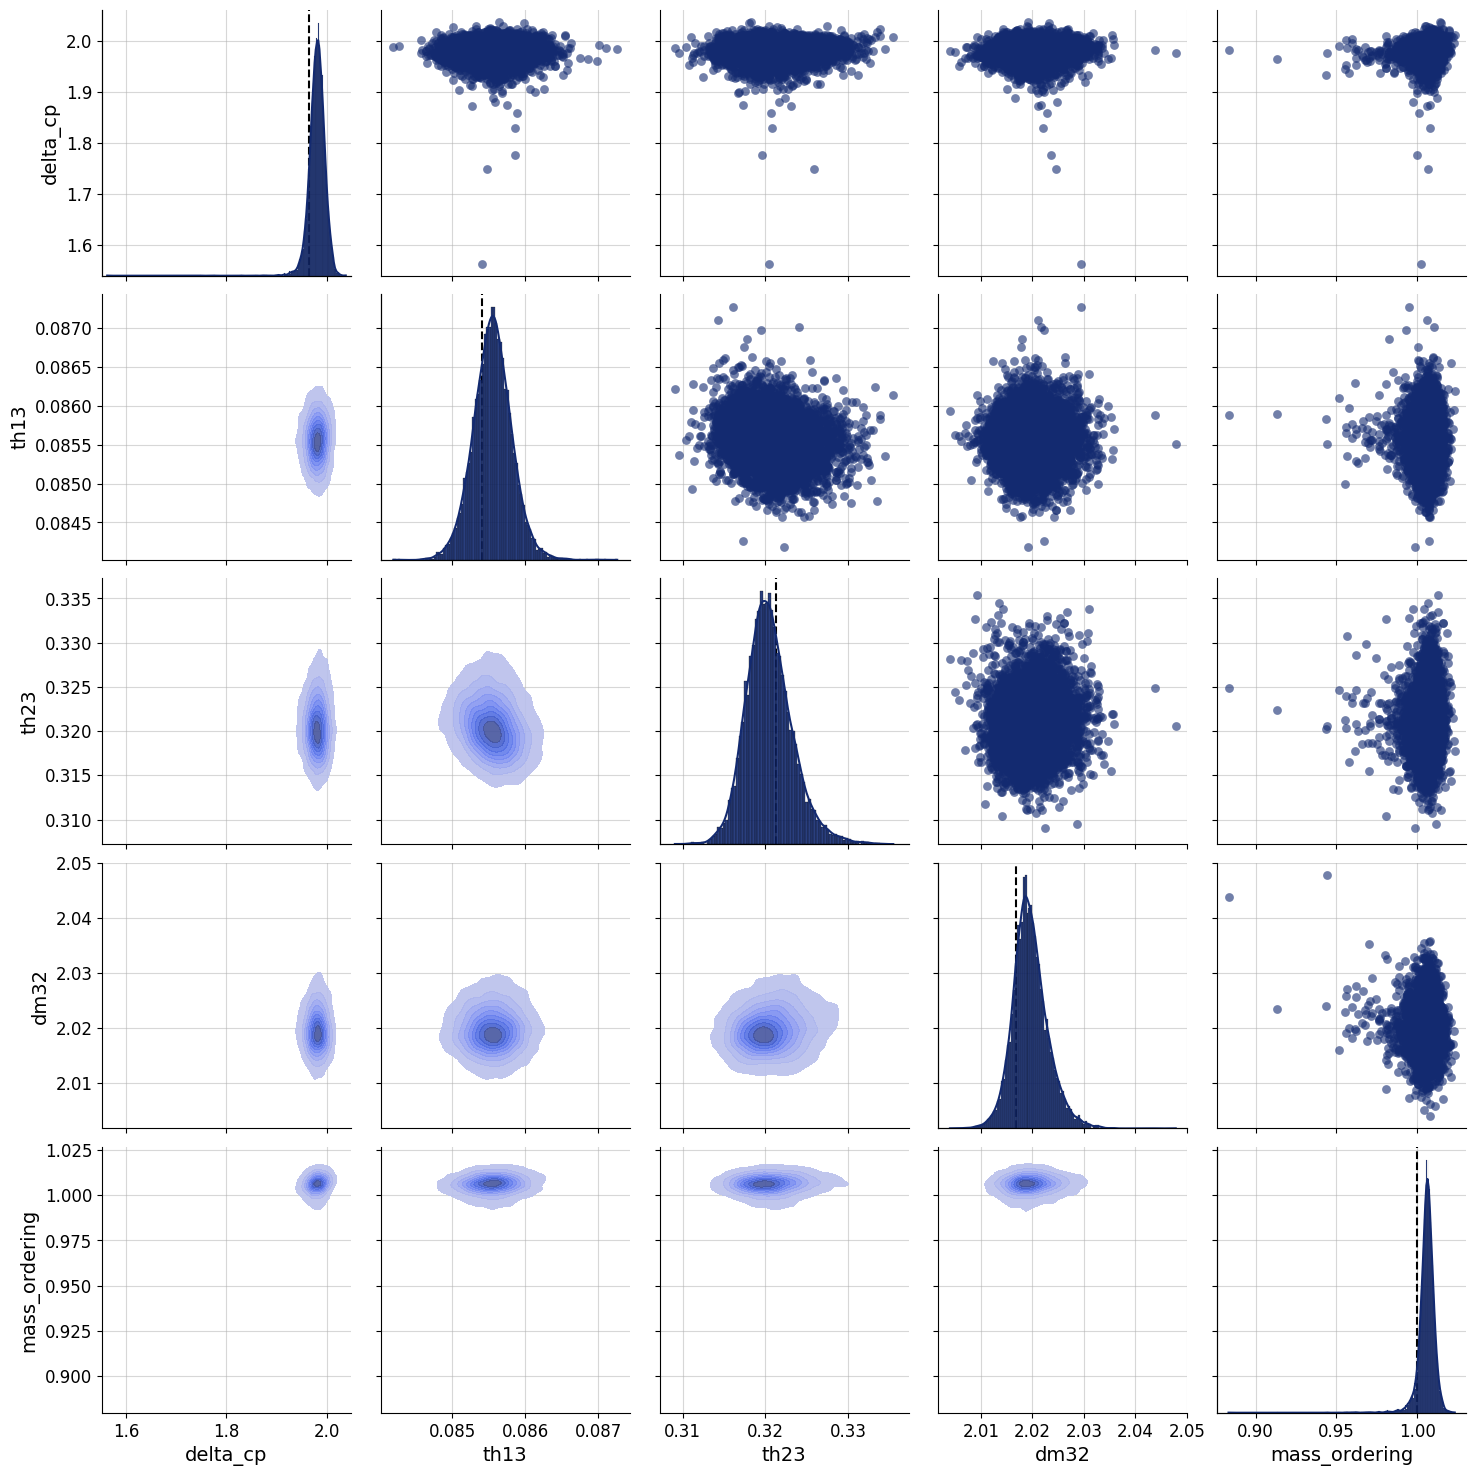

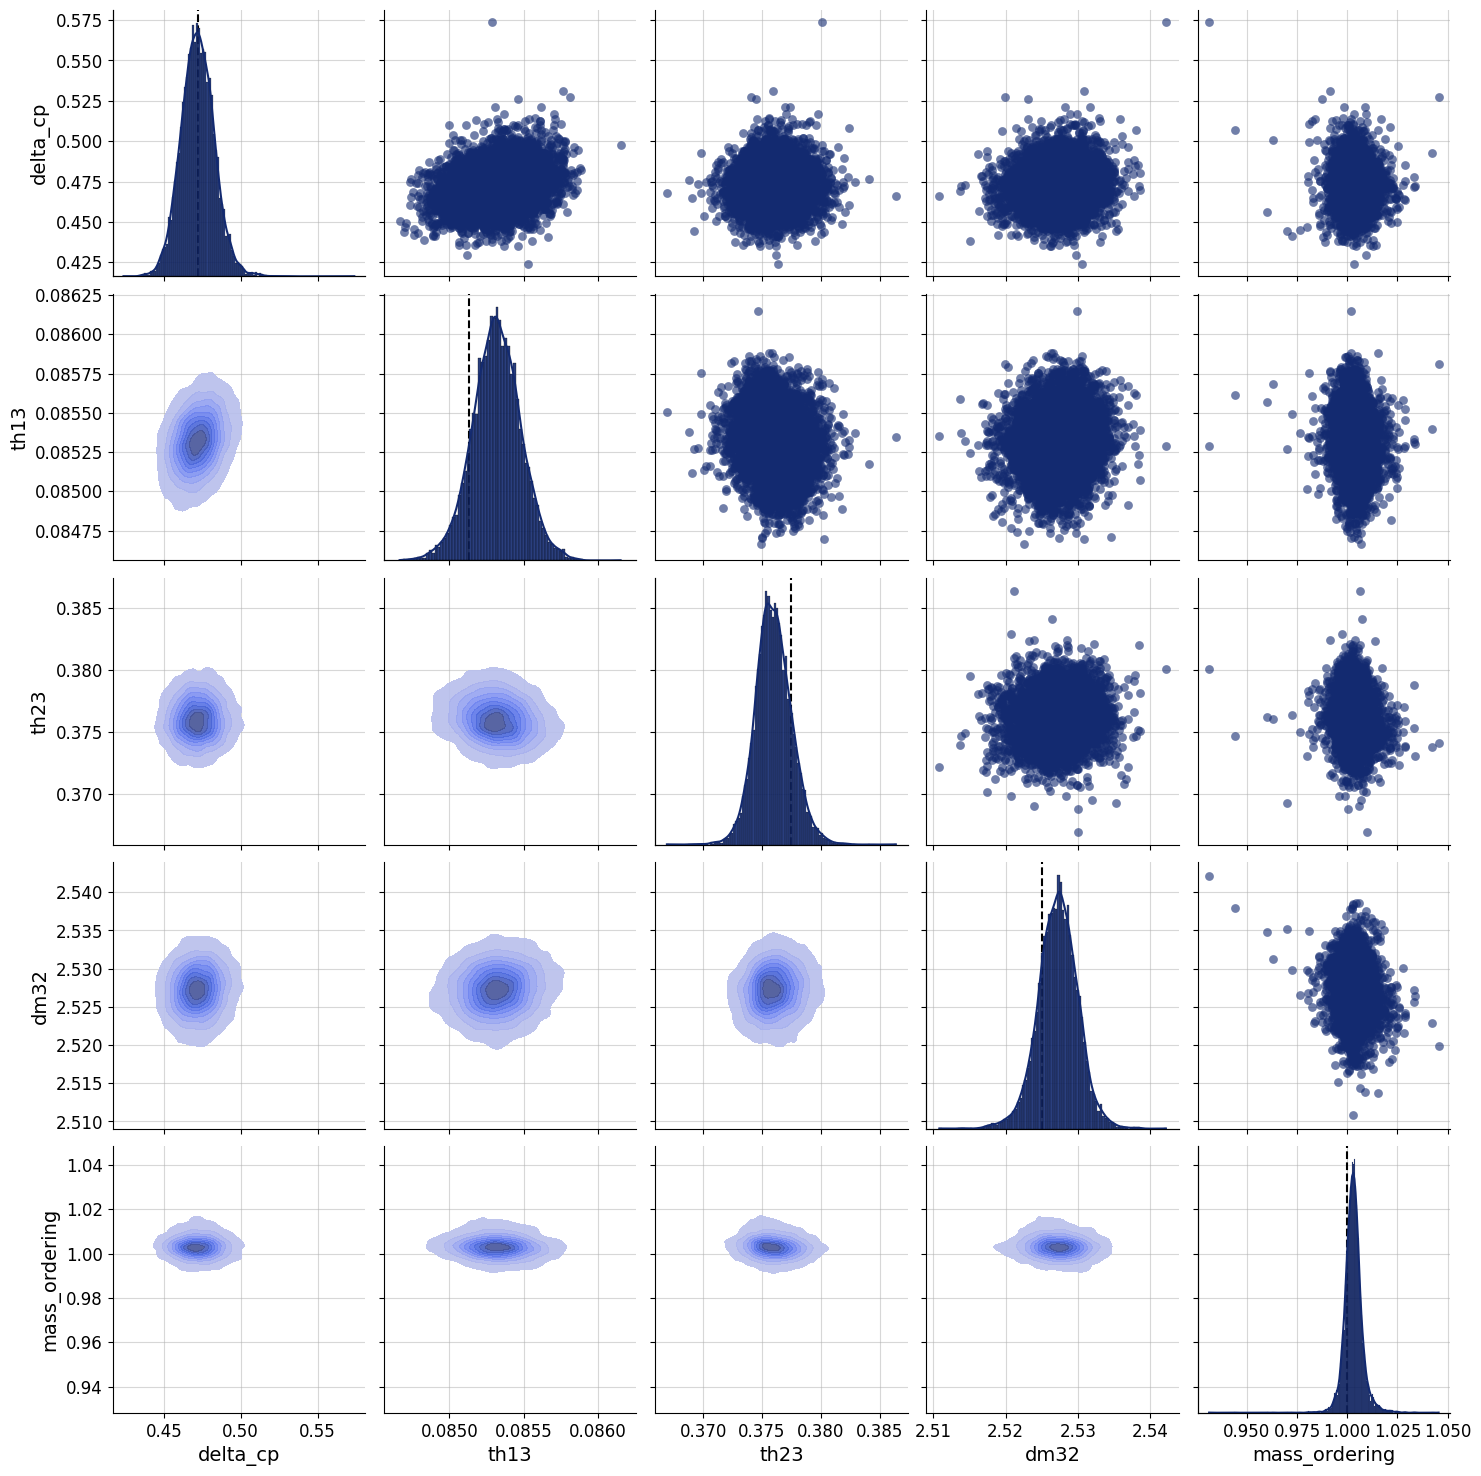

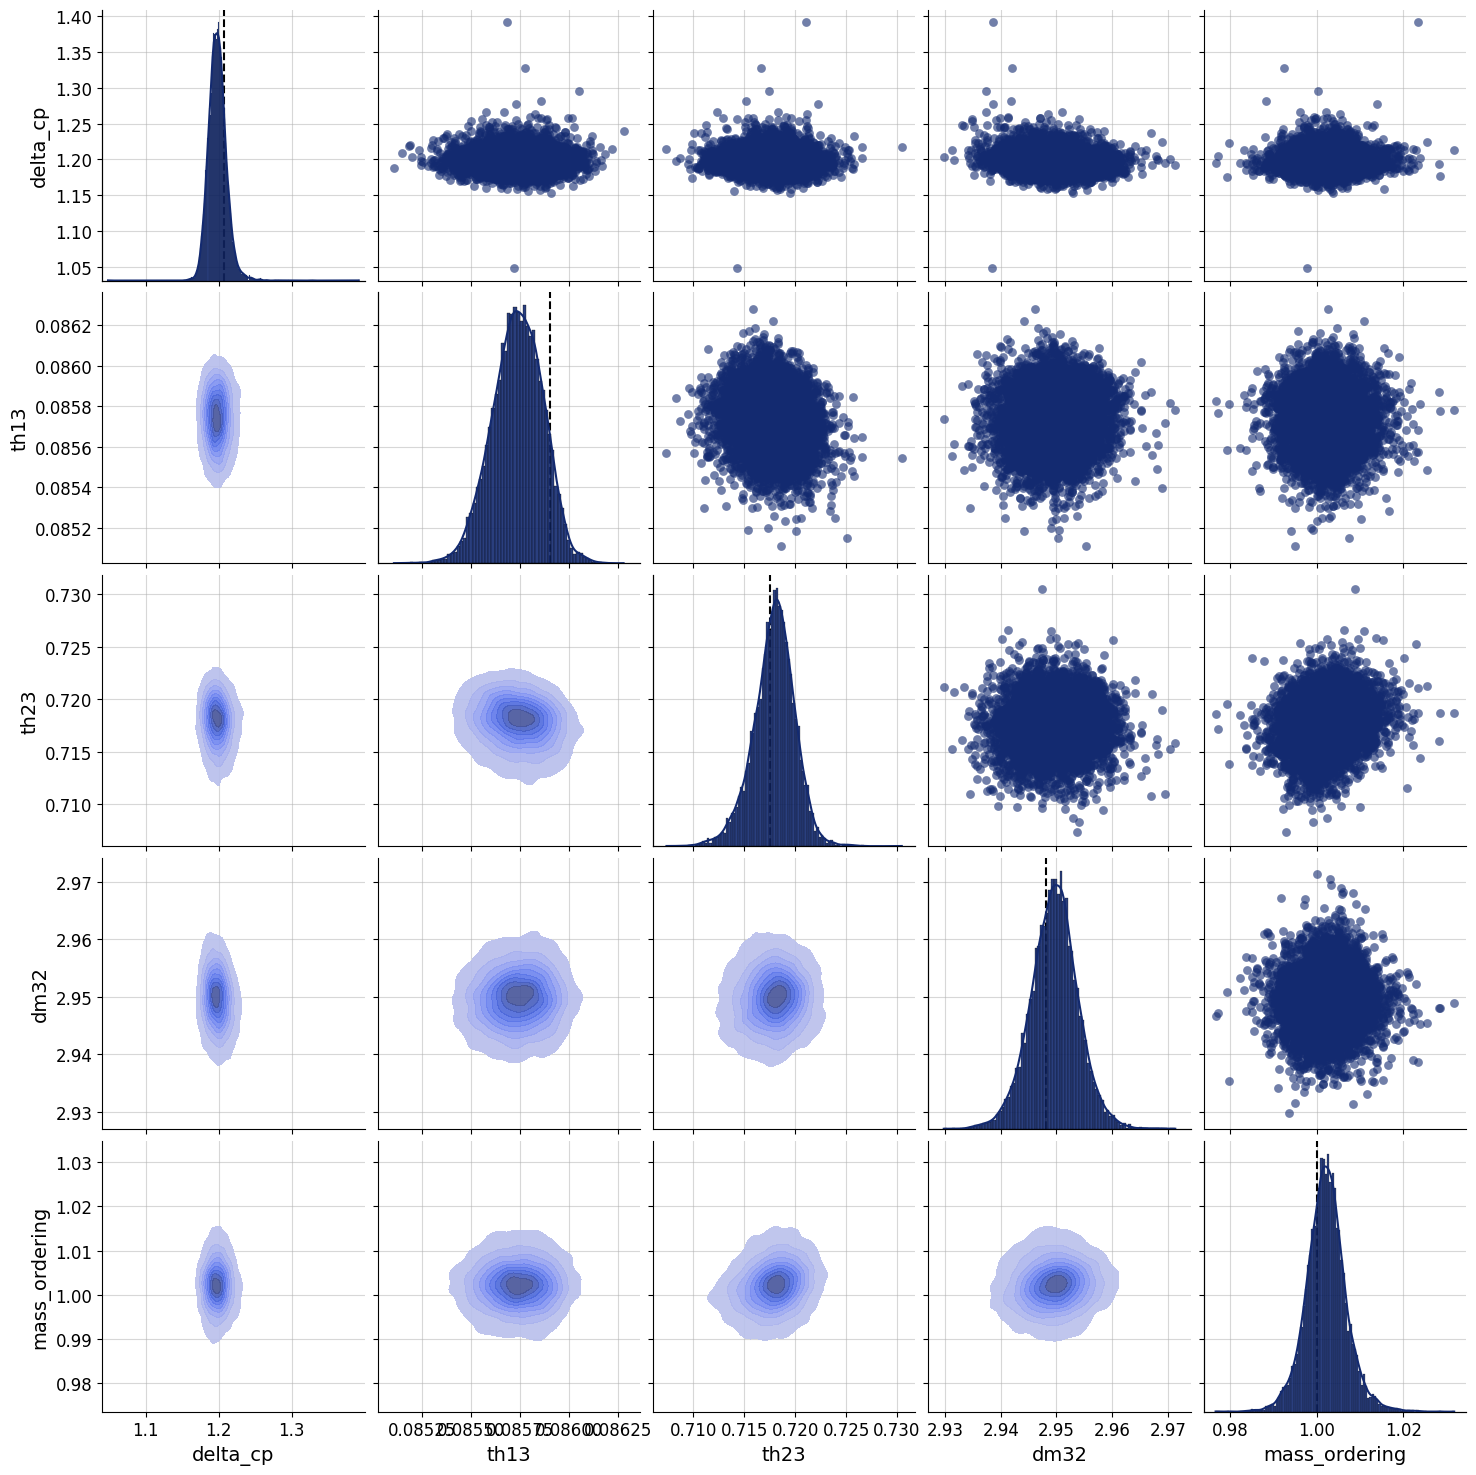

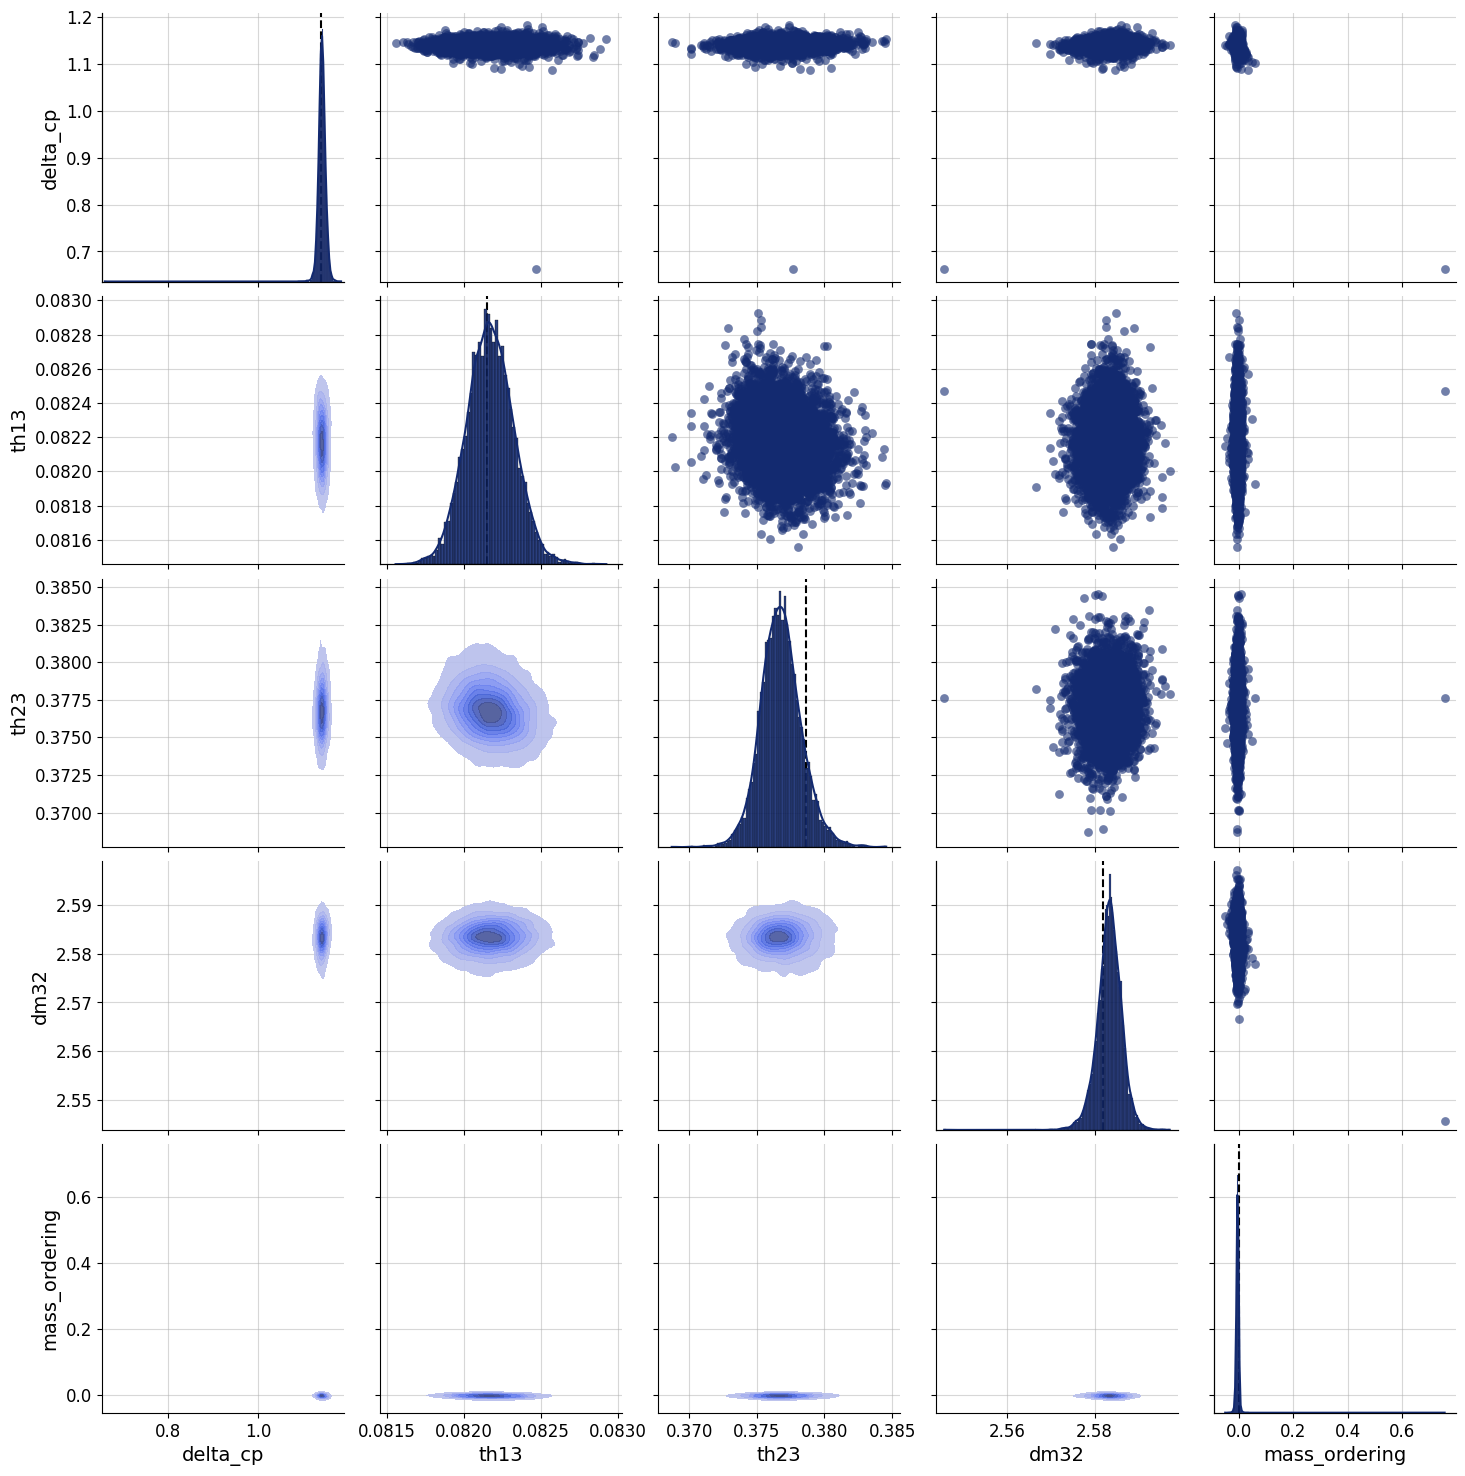

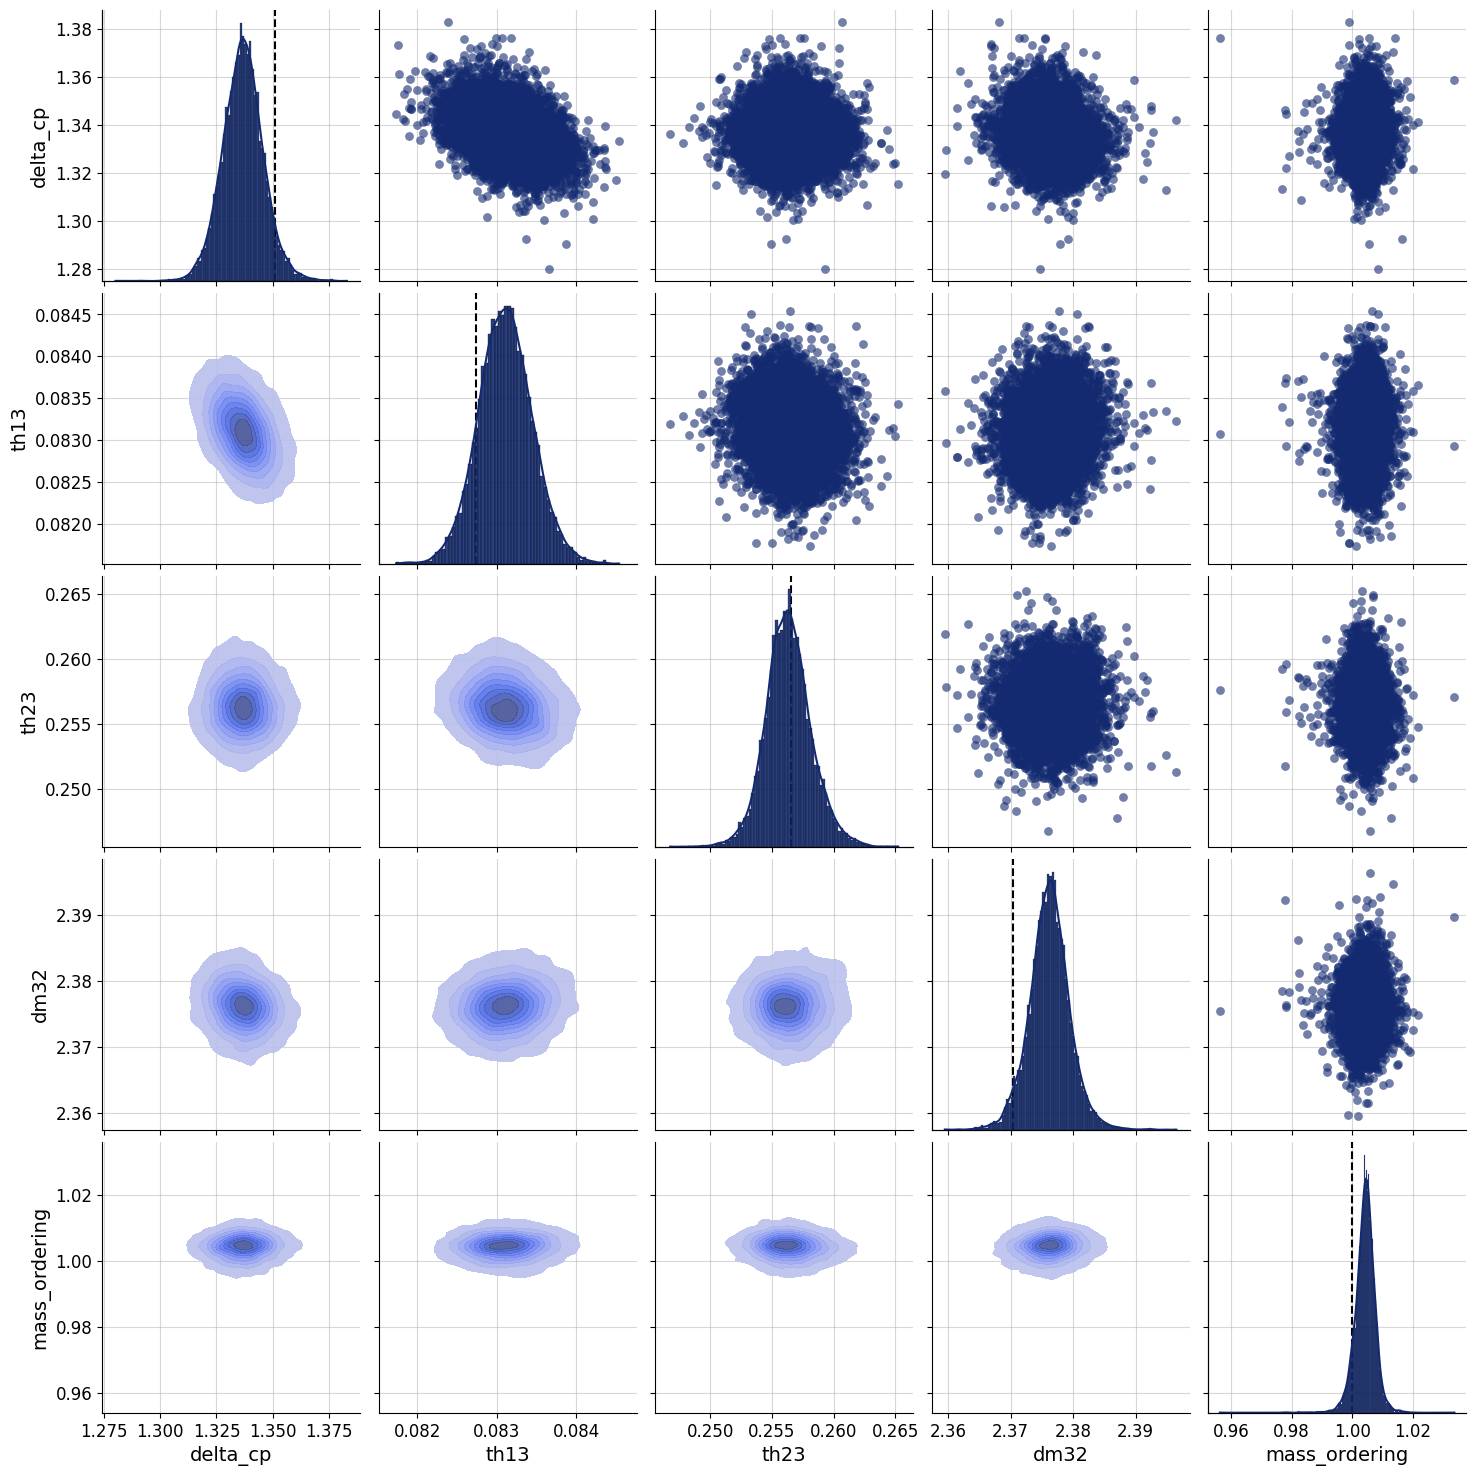

In [9]:
for n in range(5):
    print(f"Plotting pairs posterior {n}")
    bf_plots.pairs_posterior(
        estimates=test_posterior, 
        targets=testing_data_examples,
        dataset_id=n,
        variable_names=variable_names
    )

# Examining the examples
In each example we recovered the correct mass ordering, and it looks like most true value are well within 68% credible interval of the 1D posteriors (by eye). Few more observations:
1. Each posterior is quite concentrated: e.g. th13 has a very small uncertainty. Again, this is wrong, but expected given we used **expectations** rather than **predictions**.
2. The same can be said about mass ordering, where the bayes factor of one ordering over the other (e.g. values above 0.5 vs below 0.5) is always very high (by eye)
3. There is no bi-modality for theta23 (should be symmetric around ~0.5)

# Conclusions
1. ABI using NOvA emulated dataset results in an amortized model that seems to easily recover true parameter values 
2. Amortized model is many, many order of magnitude faster to sample (fully independent samples) from than Aria-CAFAna or even Stan-CAFAna with NUTS.
  - This could be used for e.g. future sensitivity studies, where we could, say, look at Bayes Factors for mass ordering given different fractions of FHC & RHC data-taking, and different true values of delta_cp. This would require many fits to do properly.
3. The model above is overfitting. This is expected, since it was trained on model **expectations** rather than model **predictions** (with poisson uncertainty around a measurement).
  - Needs to be re-done using predictions.
  - If problem persists, try more data, simpler network and/or larger dropout fraction.